In [11]:
library(coloc)
library(LDlinkR)
library(tidyverse)
library(data.table)
library(parallel)
library(GenomicRanges)
library(rtracklayer)
library(locuszoomr)
library(EnsDb.Hsapiens.v75)
library(ggpubr)
library(cowplot)
library(ComplexHeatmap)
library(circlize)
library(gridExtra)
library(cowplot)
library(patchwork)

In [12]:
gene_id_name = fread('../data/1M-scBloodNL/gene_id_name.allchrom.csv', sep='\t')
print(dim(gene_id_name))
head(gene_id_name)

[1] 22150     2


GENEID,GENENAME
<chr>,<chr>
ENSG00000238009,RP11-34P13.7
ENSG00000237683,AL627309.1
ENSG00000228463,AP006222.2
ENSG00000237094,RP4-669L17.10
ENSG00000235373,RP11-206L10.3
ENSG00000228327,RP11-206L10.2


In [13]:
celltype_map = list(B=c('bin', 'bmem', 'plasma'),
                    CD4T=c('cd4et', 'cd4nc', 'cd4sox4'),
                    CD8T=c('cd8et', 'cd8nc', 'cd8s100b'),
                    NK=c('nk', 'nkr'),
                    monocyte=c('monoc', 'mononc'),
                    DC=c('dc'))

# MS

## Process GWAS

In [14]:
selected_trait = 'ms'

In [15]:
if(selected_trait=='ms'){
sumstats <- fread('../data/blood_coloc/gwas/MS_meta_processed') %>% 
  mutate(CHR=paste0('chr', CHR)) %>% 
  dplyr::filter(!is.na(P)) %>% 
  dplyr::select(variant_id=SNP,p_value=P,chr=CHR,bp_b37=BP,effect_allele,other_allele,beta,se)

  if(file.exists('../data/blood_coloc/gwas/ms/loci_LDlinkR.r2.0.1.EUR.txt')) {
    loci <- fread('../data/blood_coloc/gwas/ms/loci_LDlinkR.r2.0.1.EUR.txt', sep='\t')
  }
}

In [5]:
dim(sumstats)

[1] 7753386       8

In [6]:
head(sumstats)

variant_id,p_value,chr,bp_b37,effect_allele,other_allele,beta,se
<chr>,<dbl>,<chr>,<int>,<chr>,<chr>,<dbl>,<dbl>
rs75454623,0.7992,chr1,14930,G,A,-0.019284761,0.07581007
rs78601809,0.7992,chr1,15211,T,G,-0.018265809,0.07180448
rs200482301,0.8047,chr1,15820,T,G,-0.014809116,0.05989069
rs138808727,0.9474,chr1,89946,T,A,-0.003104815,0.04706251
rs376723915,0.8712,chr1,91515,C,A,-0.010050336,0.06198767
rs77418980,0.9769,chr1,91536,T,G,-0.002503130,0.08644718


In [7]:
if(!file.exists('../data/blood_coloc/gwas/ms/loci_LDlinkR.r2.0.1.EUR.txt')){
  loci <- fread('../data/blood_coloc/gwas/MS_meta_indexsnp.csv', sep='\t') %>%  
    mutate(GWAS_snp_pos=paste0('chr',CHR,':',BP)) %>%
    dplyr::filter(!is.na(P))
}
dim(loci)

[1] 77 12

In [ ]:
if(!file.exists('../data/blood_coloc/gwas/ms/loci_LDlinkR.r2.0.1.EUR.txt')){
  proxy_snps <- lapply(loci$GWAS_snp_pos,LDlinkR::LDproxy,pop = "EUR", r2d = "r2", token = '72edb9cc22c9', file = FALSE)
  saveRDS(proxy_snps,'../data/blood_coloc/gwas/ms/loci_LDlinkR.allSNPs.EUR.rds')
}

In [11]:
if(!file.exists('../data/blood_coloc/gwas/ms/loci_LDlinkR.r2.0.1.EUR.txt')){
  loci <- lapply(proxy_snps,function(x){
    if(nrow(x)>1){
      x <- dplyr::filter(x,R2>=0.1) 
      chr <- x$Coord %>% gsub(':.+','',.) %>% unique()
      pos <- x$Coord %>% gsub('chr[0-9]{1,2}:','',.) %>% as.numeric()
      locus_name <- paste0(chr,':',min(pos),'_',max(pos))
      top_snp_df <- dplyr::filter(x,Distance==0) 
      top_snp <- top_snp_df %>% pull(RS_Number)
      top_snp_pos <- top_snp_df %>% pull(Coord)
      locus <- tibble(GWAS_snp=top_snp,GWAS_snp_pos=top_snp_pos,locus_name=locus_name,chrom=chr,start=min(pos),end=max(pos))
      return(locus)
    }
    else{
      return(NULL)
    }
  }) %>% bind_rows()
  write_tsv(loci,'../data/blood_coloc/gwas/ms/loci_LDlinkR.r2.0.1.EUR.txt')
}


In [5]:
if(!file.exists('../data/blood_coloc/gwas/ms/closest.protein.coding.bed')){
  sumstats_min <- sumstats %>% dplyr::select(chr,variant_id,bp_b37,beta)
}

In [15]:
if(!file.exists('../data/blood_coloc/gwas/ms/closest.protein.coding.bed')){
  gwas_snp <- tibble(GWAS_SNP_pos=unique(loci$GWAS_snp_pos)) %>% 
    separate(GWAS_SNP_pos,into=c('chr','bp_b37'),sep=':') %>% 
    mutate(end=bp_b37) %>% 
    mutate(bp_b37=as.numeric(bp_b37)) %>% 
    left_join(.,sumstats_min,by=c('chr','bp_b37')) %>% 
    arrange(chr,bp_b37) %>% 
    write_tsv(.,'../data/blood_coloc/gwas/ms/ms_GWAS_index_snps.v2.bed',col_names = FALSE)
}

In [ ]:
cd data/gwas/ms
ln -s ../data/brain_coloc/gencode/gencode.v39lift37.annotation.protein_coding.1_22.bed .

ml bedtools/2.25.0-goolf-1.7.20
bedtools closest -d -wa -a ms_GWAS_index_snps.v2.bed -b gencode.v39lift37.annotation.protein_coding.1_22.bed > closest.protein.coding.bed

In [16]:
if(file.exists('../data/blood_coloc/gwas/ms/loci_LDlinkR.r2.0.1.EUR.txt')){
    loci <- fread('../data/blood_coloc/gwas/ms/loci_LDlinkR.r2.0.1.EUR.txt', sep='\t')
}
closest <- fread(paste0('../data/blood_coloc/gwas/ms/closest.protein.coding.bed'),sep='\t', header=FALSE) %>% 
  setNames(c('chr_snp','start_snp','end_snp','GWAS_snp','beta','chr_gene','start_gene','end_gene','gene','distance')) %>% 
  mutate(GWAS_snp_pos=paste0(chr_snp,':',start_snp)) %>% 
  dplyr::select(GWAS_snp,GWAS_snp_pos,gene,beta,distance) %>% 
  separate(gene,into=c('symbol','ensembl'),sep='_') %>% 
  add_count(GWAS_snp) %>% 
  group_by(GWAS_snp) %>% 
  mutate(locus_name_gene=ifelse(n==1,symbol,paste0(symbol,collapse=' - '))) %>% 
  ungroup() %>% 
  dplyr::select(GWAS_snp_pos,locus_name_gene,beta_top_GWAS=beta) %>% 
  unique() %>% arrange(-abs(beta_top_GWAS))
loci <- left_join(loci,closest,by='GWAS_snp_pos')
dim(loci)

[1] 77  8

In [17]:
head(loci)

GWAS_snp,GWAS_snp_pos,locus_name,chrom,start,end,locus_name_gene,beta_top_GWAS
<chr>,<chr>,<chr>,<chr>,<int>,<int>,<chr>,<dbl>
rs6670198,chr1:2520527,chr1:2407781_2779397,chr1,2407781,2779397,PRXL2B,-0.1450258
rs35486093,chr1:85729820,chr1:85416840_86010196,chr1,85416840,86010196,BCL10,-0.1794856
rs139504223,chr1:93152635,chr1:92652691_93519650,chr1,92652691,93519650,EVI5,-0.1444479
rs74449127,chr1:101290432,chr1:101212872_101621089,chr1,101212872,101621089,EXTL2,0.1969638
rs10801908,chr1:117090493,chr1:117032885_117104215,chr1,117032885,117104215,CD58,0.2149501
rs483180,chr1:120267505,chr1:120135045_120341256,chr1,120135045,120341256,PHGDH,-0.1082536


## Run coloc

### eqtl and ibsep

In [22]:
# eqtl_ex <- prepare_eqtl(micro,chrom_locus,sumstats_locus)
prepare_eqtl_ibsep <- function(eqtl_name,ibsep_name,chrom_locus,sumstats_locus){
  # eqtl
  file <- sprintf('../data/blood_data/1M/merged_sumstats/by_chrom_gene/%s/%s.csv', chrom_locus, eqtl_name)
  eqtl <- data.table::fread(file, header=TRUE, nThread=1) %>%
    dplyr::select(gene_id=GENEID, gene=GENENAME, SNP, A1, A2, p_eqtl=PVAL, beta_eqtl=BETA, se_eqtl=SE) %>%
    inner_join(.,sumstats_locus[,c('variant_id','effect_allele','other_allele','SNP_id_hg19')],
               by=join_by(SNP==variant_id),multiple='first')
  message(nrow(sumstats_locus))
  message(nrow(eqtl))
  eqtl <- eqtl %>%
    dplyr::filter(((A1==effect_allele)&(A2==other_allele)) | ((A2==effect_allele)&(A1==other_allele))) %>%
    dplyr::select(gene_id, gene, SNP, SNP_id_hg19, effect_allele=A2, other_allele=A1, p_eqtl, beta_eqtl, se_eqtl)
  message(nrow(eqtl))

  if(nrow(eqtl)==0){
      message('nrow(eqtl)==0')
  }
    
  # ibsep
  file <- sprintf('../data/blood_data/1M/merged_sumstats/omega_shrink_0.9_max_hsq_0.8/%s/%s.csv', chrom_locus, ibsep_name)
  
  ibsep <- data.table::fread(file, header=TRUE, nThread=1) %>%
    dplyr::select(SNP=SNP_1M, gene_id=GENEID_1M, BETA_BLUE, SE_BLUE, PVAL_BLUE)

  # merge eqtl and ibsep
  merged <- inner_join(eqtl,ibsep,by=c('gene_id', 'SNP'))
  merged <- merged[(is.na(merged$BETA_BLUE)==FALSE)&(is.na(merged$SE_BLUE)==FALSE),]
  merged <- merged %>%
    add_count(gene_id) %>% 
    dplyr::filter(n>10)
    
  return(merged)
}

In [ ]:
## ibsep
t0 = Sys.time()
coloc_ibsep_results_all <- mclapply(1:nrow(loci),function(i){

  #Get coordinates from the GWAS locus
  chrom_locus <- loci$chrom[i]
  start <- loci$start[i] %>% as.numeric()
  end <- loci$end[i] %>% as.numeric()
  
  closest_gene_locus <- loci$locus_name_gene[i]
  beta_top_GWAS_locus <- loci$beta_top_GWAS[i]
  GWAS_snp_name <- loci$GWAS_snp[i]
  GWAS_snp_pos_name <- loci$GWAS_snp_pos[i]

  #Keep GWAS sumstats of SNPs in the locus
  sumstats_locus <- dplyr::filter(sumstats,chr==chrom_locus) %>% 
    dplyr::filter(bp_b37>=start & bp_b37<=end) %>% 
    dplyr::mutate(SNP_id_hg19=paste0(chr,':',bp_b37))

  #Preparing eQTL files - keeping SNPs from the eQTL data that match SNPs in the GWAS locus
  eqtl_b <- prepare_eqtl_ibsep('allgenes_B','allgenes_B_IBSEP_truncorr_pval1e-10',chrom_locus,sumstats_locus)
  eqtl_cd4 <- prepare_eqtl_ibsep('allgenes_CD4T','allgenes_CD4T_IBSEP_truncorr_pval1e-10',chrom_locus,sumstats_locus)
  eqtl_cd8 <- prepare_eqtl_ibsep('allgenes_CD8T','allgenes_CD8T_IBSEP_truncorr_pval1e-10',chrom_locus,sumstats_locus)
  eqtl_nk <- prepare_eqtl_ibsep('allgenes_NK','allgenes_NK_IBSEP_truncorr_pval1e-10',chrom_locus,sumstats_locus)
  eqtl_mono <- prepare_eqtl_ibsep('allgenes_monocyte','allgenes_monocyte_IBSEP_truncorr_pval1e-10',chrom_locus,sumstats_locus)
  eqtl_dc <- prepare_eqtl_ibsep('allgenes_DC','allgenes_DC_IBSEP_truncorr_pval1e-10',chrom_locus,sumstats_locus)

  #Running colocalization analysis
  b_coloc <- run_coloc_ibsep(eqtl_b,'B',sumstats_locus)
  cd4_coloc <- run_coloc_ibsep(eqtl_cd4,'CD4T',sumstats_locus)
  cd8_coloc <- run_coloc_ibsep(eqtl_cd8,'CD8T',sumstats_locus)
  nk_coloc <- run_coloc_ibsep(eqtl_nk,'NK',sumstats_locus)
  mono_coloc <- run_coloc_ibsep(eqtl_mono,'monocyte',sumstats_locus)
  dc_coloc <- run_coloc_ibsep(eqtl_dc,'DC',sumstats_locus)
  
  pval_eqtl <- rbind(b_coloc,cd4_coloc,cd8_coloc,nk_coloc,mono_coloc,dc_coloc)
  
  if(!is.null(pval_eqtl)){
    pval_eqtl <- pval_eqtl %>% 
      mutate(type='eQTL',
           locus=loci$locus_name[i],
           coloc_method='beta') %>% 
      mutate(closest_gene=closest_gene_locus,
             beta_top_GWAS=beta_top_GWAS_locus,
             GWAS_snp=GWAS_snp_name,
             GWAS_snp_pos=GWAS_snp_pos_name)
  }
  results <- pval_eqtl 
  if(!is.null(results)){
    results <- results %>% 
      arrange(-PP.H4.abf) %>% 
      dplyr::select(locus,closest_gene,GWAS_snp,GWAS_snp_pos,beta_top_GWAS,everything())
  }
  
  return(results)
},mc.cores = 36,mc.preschedule = FALSE)
t1 = Sys.time()

In [15]:
t1 - t0

Time difference of 14.10643 secs

In [ ]:
coloc_ibsep_results_all_success = list()
n = 1
for(i in 1:length(coloc_ibsep_results_all)){
    if(!is.null(dim(coloc_ibsep_results_all[[i]]))==TRUE){
        coloc_ibsep_results_all_success[[n]] = coloc_ibsep_results_all[[i]]
        n = n + 1
    }
}
length(coloc_ibsep_results_all_success)

coloc_ibsep_results_all_df <- coloc_ibsep_results_all_success %>% 
  bind_rows() %>% 
  arrange(-PP.H4.abf) %>% 
  separate(gene,into=c('symbol','ensembl'),sep='_')
dim(coloc_ibsep_results_all_df)

fwrite(coloc_ibsep_results_all_df, '../data/blood_coloc/result/ms_ibsep.csv', sep='\t')

In [ ]:
## ori eqtl
t0 = Sys.time()
coloc_eqtl_results_all <- mclapply(1:nrow(loci),function(i){

  #Get coordinates from the GWAS locus
  chrom_locus <- loci$chrom[i]
  start <- loci$start[i] %>% as.numeric()
  end <- loci$end[i] %>% as.numeric()
  
  closest_gene_locus <- loci$locus_name_gene[i]
  beta_top_GWAS_locus <- loci$beta_top_GWAS[i]
  GWAS_snp_name <- loci$GWAS_snp[i]
  GWAS_snp_pos_name <- loci$GWAS_snp_pos[i]

  #Keep GWAS sumstats of SNPs in the locus
  sumstats_locus <- dplyr::filter(sumstats,chr==chrom_locus) %>% 
    dplyr::filter(bp_b37>=start & bp_b37<=end) %>% 
    dplyr::mutate(SNP_id_hg19=paste0(chr,':',bp_b37))

  #Preparing eQTL files - keeping SNPs from the eQTL data that match SNPs in the GWAS locus
  eqtl_b <- prepare_eqtl_ibsep('allgenes_B','allgenes_B_IBSEP_truncorr_pval1e-10',chrom_locus,sumstats_locus)
  eqtl_cd4 <- prepare_eqtl_ibsep('allgenes_CD4T','allgenes_CD4T_IBSEP_truncorr_pval1e-10',chrom_locus,sumstats_locus)
  eqtl_cd8 <- prepare_eqtl_ibsep('allgenes_CD8T','allgenes_CD8T_IBSEP_truncorr_pval1e-10',chrom_locus,sumstats_locus)
  eqtl_nk <- prepare_eqtl_ibsep('allgenes_NK','allgenes_NK_IBSEP_truncorr_pval1e-10',chrom_locus,sumstats_locus)
  eqtl_mono <- prepare_eqtl_ibsep('allgenes_monocyte','allgenes_monocyte_IBSEP_truncorr_pval1e-10',chrom_locus,sumstats_locus)
  eqtl_dc <- prepare_eqtl_ibsep('allgenes_DC','allgenes_DC_IBSEP_truncorr_pval1e-10',chrom_locus,sumstats_locus)

  #Running colocalization analysis
  b_coloc <- run_coloc(eqtl_b,'B',sumstats_locus)
  cd4_coloc <- run_coloc(eqtl_cd4,'CD4T',sumstats_locus)
  cd8_coloc <- run_coloc(eqtl_cd8,'CD8T',sumstats_locus)
  nk_coloc <- run_coloc(eqtl_nk,'NK',sumstats_locus)
  mono_coloc <- run_coloc(eqtl_mono,'monocyte',sumstats_locus)
  dc_coloc <- run_coloc(eqtl_dc,'DC',sumstats_locus)
  
  pval_eqtl <- rbind(b_coloc,cd4_coloc,cd8_coloc,nk_coloc,mono_coloc,dc_coloc)
  
  if(!is.null(pval_eqtl)){
    pval_eqtl <- pval_eqtl %>% 
      mutate(type='eQTL',
           locus=loci$locus_name[i],
           coloc_method='beta') %>% 
      mutate(closest_gene=closest_gene_locus,
             beta_top_GWAS=beta_top_GWAS_locus,
             GWAS_snp=GWAS_snp_name,
             GWAS_snp_pos=GWAS_snp_pos_name)
  }
  results <- pval_eqtl 
  if(!is.null(results)){
    results <- results %>% 
      arrange(-PP.H4.abf) %>% 
      dplyr::select(locus,closest_gene,GWAS_snp,GWAS_snp_pos,beta_top_GWAS,everything())
  }
  
  return(results)
},mc.cores = 36,mc.preschedule = FALSE)
t1 = Sys.time()

In [25]:
t1 - t0

Time difference of 14.27517 secs

In [ ]:
coloc_eqtl_results_all_success = list()
n = 1
for(i in 1:length(coloc_eqtl_results_all)){
    if(!is.null(dim(coloc_eqtl_results_all[[i]]))==TRUE){
        coloc_eqtl_results_all_success[[n]] = coloc_eqtl_results_all[[i]]
        n = n + 1
    }
}
length(coloc_eqtl_results_all_success)

coloc_eqtl_results_all_df <- coloc_eqtl_results_all_success %>% 
  bind_rows() %>% 
  arrange(-PP.H4.abf) %>% 
  separate(gene,into=c('symbol','ensembl'),sep='_')
dim(coloc_eqtl_results_all_df)

In [28]:
fwrite(coloc_eqtl_results_all_df, '../data/blood_coloc/result/ms_eqtl.csv', sep='\t')

## Plot

### eqtl, ibsep and 1k1k

In [5]:
eqtl_res = fread('../data/blood_coloc/result/ms_eqtl.csv', sep='\t')
ibsep_res = fread('../data/blood_coloc/result/ms_ibsep.csv', sep='\t')
onek1k_res = fread('../data/blood_coloc/result/ms_1k1k.csv', sep='\t')
print(dim(eqtl_res))
print(dim(ibsep_res))
print(dim(onek1k_res))

[1] 1356   21
[1] 1356   21
[1] 3164   21


In [6]:
eqtl_sig <- eqtl_res[eqtl_res$PP.H4.abf > 0.7] %>% mutate(method='Single cell')
ibsep_sig <- ibsep_res[ibsep_res$PP.H4.abf > 0.7] %>% mutate(method='IBSEP')
onek1k_sig <- onek1k_res[onek1k_res$PP.H4.abf > 0.7] %>% mutate(method='OneK1K')
print(dim(eqtl_sig))
print(dim(ibsep_sig))
print(dim(onek1k_sig))

comb_sig <- bind_rows(eqtl_sig, ibsep_sig) 
comb_sig <- comb_sig %>% arrange(closest_gene, symbol)
comb_sig_min <- comb_sig[,c('locus', 'closest_gene', 'symbol')] %>% distinct()

print(dim(comb_sig))
print(dim(comb_sig_min))
eqtl_res_wide = eqtl_res[,c('locus', 'closest_gene', 'symbol', 'tissue', 'PP.H4.abf')] %>%
    dplyr::filter(!is.na(PP.H4.abf)) %>%
    dplyr::group_by(locus, closest_gene, symbol, tissue) %>%
    dplyr::slice(which.max(PP.H4.abf)) %>%
    pivot_wider(names_from=tissue, values_from=PP.H4.abf, values_fill=0.0)
ibsep_res_wide = ibsep_res[,c('locus', 'closest_gene', 'symbol', 'tissue', 'PP.H4.abf')] %>%
    dplyr::filter(!is.na(PP.H4.abf)) %>%
    dplyr::group_by(locus, closest_gene, symbol, tissue) %>%
    dplyr::slice(which.max(PP.H4.abf)) %>%
    pivot_wider(names_from=tissue, values_from=PP.H4.abf, values_fill=0.0)
print(dim(eqtl_res_wide))
print(dim(ibsep_res_wide))
eqtl_comb_sig_wide = inner_join(comb_sig_min, eqtl_res_wide, by=c('locus', 'closest_gene', 'symbol'))
ibsep_comb_sig_wide = inner_join(comb_sig_min, ibsep_res_wide, by=c('locus', 'closest_gene', 'symbol'))
eqtl_comb_sig_wide <- eqtl_comb_sig_wide %>% 
    arrange(closest_gene, symbol) %>%
    relocate(all_of(sort(colnames(eqtl_comb_sig_wide)[4:9])), .after='symbol')
ibsep_comb_sig_wide <- ibsep_comb_sig_wide %>% 
    arrange(closest_gene, symbol) %>%
    relocate(all_of(sort(colnames(ibsep_comb_sig_wide)[4:9])), .after='symbol')
print(dim(eqtl_comb_sig_wide))
print(dim(ibsep_comb_sig_wide))

[1] 21 22
[1] 62 22
[1] 89 22
[1] 83 23
[1] 25  3
[1] 219   9
[1] 219   9
[1] 25  9
[1] 25  9


In [7]:
onek1k_sig <- onek1k_sig %>% arrange(closest_gene, symbol)
onek1k_sig_min <- onek1k_sig[,c('locus', 'closest_gene', 'symbol')] %>% distinct()

print(dim(onek1k_sig))
print(dim(onek1k_sig_min))
onek1k_res_wide = onek1k_res[,c('locus', 'closest_gene', 'symbol', 'tissue', 'PP.H4.abf')] %>%
    dplyr::filter(!is.na(PP.H4.abf)) %>%
    dplyr::group_by(locus, closest_gene, symbol, tissue) %>%
    dplyr::slice(which.max(PP.H4.abf)) %>%
    pivot_wider(names_from=tissue, values_from=PP.H4.abf, values_fill=0.0)
print(dim(onek1k_res_wide))
onek1k_sig_wide = inner_join(onek1k_sig_min, onek1k_res_wide, by=c('locus', 'closest_gene', 'symbol'))
onek1k_sig_wide <- onek1k_sig_wide %>% 
    arrange(closest_gene, symbol) %>%
    relocate(all_of(sort(colnames(onek1k_sig_wide)[4:17])), .after='symbol')
print(dim(onek1k_sig_wide))

[1] 89 22
[1] 34  3
[1] 219  17
[1] 34 17


In [8]:
mat = matrix(nrow=nrow(eqtl_comb_sig_wide), ncol=6)
fun <- function(x, y, loc, gene, sym, sub_cts){
    if((x>0.7) & (y>0.7)){
        z = 1
    }else if((x>0.7) & (y<=0.7)){
        z = 2
    }else if((x<=0.7) & (y>0.7)){
        z = 3
    }else{
        z = 0
    }
    l = c()
    for(sub_ct in sub_cts){
        tmp = onek1k_sig_wide[(onek1k_sig_wide$locus==loc) & (onek1k_sig_wide$closest_gene==gene) & (onek1k_sig_wide$symbol==sym)]
        if(nrow(tmp) > 0){
            v = tmp[[sub_ct]]
            if(!is.na(v)){
                l = c(l, v)
            }
        }
    }
    
    if(length(l)>0){
        if(max(l)>0.7){
            z = z*10
        }
    }
    return(z)
}
mat1 = as.matrix(eqtl_comb_sig_wide[,c(4:9)])
mat2 = as.matrix(ibsep_comb_sig_wide[,c(4:9)])
for(i in 1:nrow(mat)){
    for(j in 1:ncol(mat)){
        loc = eqtl_comb_sig_wide$locus[i]
        gene = eqtl_comb_sig_wide$closest_gene[i]
        sym = eqtl_comb_sig_wide$symbol[i]
        ct = colnames(eqtl_comb_sig_wide)[3+j]
        sub_cts = celltype_map[[ct]]
        mat[i,j] = fun(mat1[i,j], mat2[i,j], loc, gene, sym, sub_cts)
    }
}

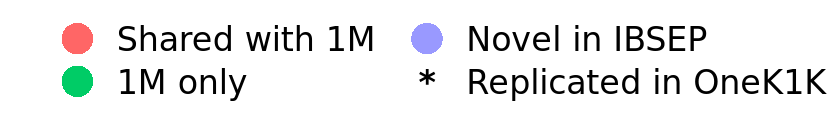

In [236]:
options(repr.plot.width=4.2, repr.plot.height=0.6, repr.plot.res=200)
text_color = '#FFFFFF'
offset = 4
lgd = Legend(labels = c('Shared with 1M', '1M only', 'Novel in IBSEP', 'Replicated in OneK1K'), 
             ncol=2, column_gap = unit(6, "mm"), row_gap = unit(1, 'mm'),
             legend_gp = gpar(fill = 'orange'),
             labels_gp = gpar(fontsize=12, fontfamily='ArialMT'), grid_width = unit(8, "mm"),
    graphics = list(
        function(x, y, w, h) grid.circle(x = x, y = y, r = unit(2, "mm"), 
                gp = gpar(fill = colors['1'], col = NA)),
        function(x, y, w, h) grid.circle(x = x, y = y, r = unit(2, "mm"), 
                gp = gpar(fill = colors['2'], col = NA)),
        function(x, y, w, h) grid.circle(x = x, y = y, r = unit(2, "mm"), 
                gp = gpar(fill = colors['3'], col = NA)),
        function(x, y, w, h){
            grid.text('*', x=x, y=y, 
                      gp=gpar(fill=text_color, fontface='bold'))
        }
    ))
draw(lgd)

In [9]:
sorted_cell_names = c('B', 'CD4', 'CD8', 'NK', 'Monocyte', 'DC')

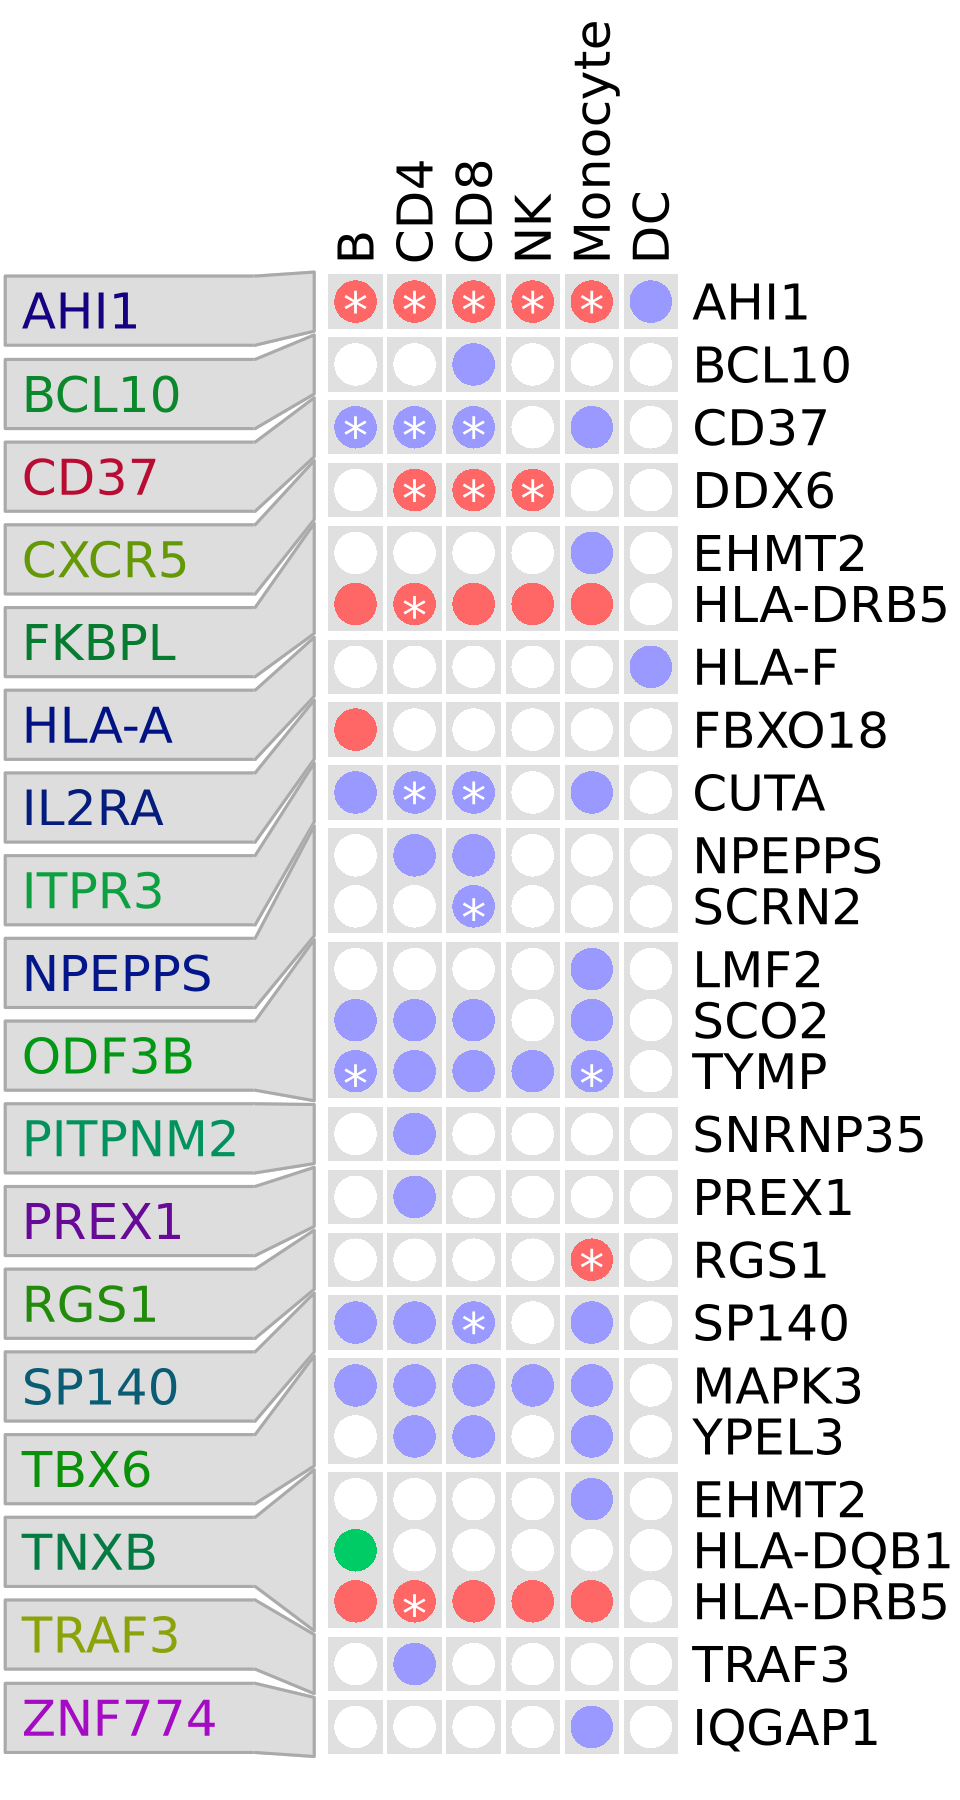

In [10]:
mat_reorder = mat[,c(1,2,3,6,5,4)]
options(repr.matrix.max.cols=100, repr.matrix.max.rows=100)
options(repr.plot.width=3.2, repr.plot.height=6, repr.plot.res=300)
col_fun = colorRamp2(c(0, 1, 2, 3), c("grey", "red", "green", "blue"))
colors = structure(c("#FFFFFF", "#FF6666", "#00CC66", "#9999FF"), names = c(0,1,2,3))
text_color = '#FFFFFF'
# cyto = sapply(eqtl_comb_sig_wide$locus, get_cytoband)
split = eqtl_comb_sig_wide$closest_gene
# split = paste(cyto, split)
text = as.list(unique(split))
names(text) = unique(split)
w = ncol(mat)*unit(5, "mm")
h = nrow(mat)*unit(5, "mm")
ht = Heatmap(mat_reorder, col=colors, rect_gp = gpar(type = "none"),
        cluster_rows = FALSE, cluster_columns = FALSE,
        cell_fun = function(j, i, x, y, width, height, fill) {
            c_idx = ifelse(mat_reorder[i,j]<10, mat_reorder[i, j]+1, as.integer(mat_reorder[i,j]/10)+1)
            grid.rect(x = x, y = y, width = unit(4.6, 'mm'), height = unit(4.6, 'mm'),
                     gp = gpar(fill = '#E0E0E0', col = NA))
           grid.circle(x = x, y = y, r = unit(1.8, "mm"), 
                gp = gpar(fill = colors[c_idx], col = NA))
            if(mat_reorder[i,j]>=10){
                grid.text('*', x=x, y=unit(as.numeric(y)+1,'mm'), gp=gpar(col=text_color))
            }
           },
        right_annotation=rowAnnotation(labels = anno_text(eqtl_comb_sig_wide$symbol, which='row'), gp = gpar(fontsize = 8)),
        top_annotation=columnAnnotation(labels = anno_text(sorted_cell_names, 
                                                              which='column', just='left', location=unit(0, 'npc')), gp = gpar(fontsize = 10)),
         column_names_side = c("top"),
        row_title_gp = gpar(fontsize = 12),
        row_title_rot = 0,
       width = w, height = h,
       row_split=split,
        row_title=NULL,
        left_annotation = rowAnnotation(Locus = anno_textbox(split, text, side='left')),
       column_gap = unit(0, "mm"), border = FALSE,
       show_column_names=TRUE, show_heatmap_legend=FALSE,
       heatmap_legend_param = list(title='', 
                                   labels=c('Null', 'Shared', 'Only single cell', 'Only IBSEP'),
                                  grid_height = unit(5, "mm"), grid_width = unit(5, "mm"),
                                   labels_gp = gpar(fontsize = 14))
        )
draw(ht)
# draw(ht, annotation_legend_list = lgd, annotation_legend_side = "bottom")

### locuszoomr

In [18]:
#Get coordinates from the GWAS locus
i = which(loci$locus_name_gene=='CD37')
chrom_locus <- loci$chrom[i]
start <- loci$start[i] %>% as.numeric()
end <- loci$end[i] %>% as.numeric()

closest_gene_locus <- loci$locus_name_gene[i]
beta_top_GWAS_locus <- loci$beta_top_GWAS[i]
GWAS_snp_name <- loci$GWAS_snp[i]
GWAS_snp_pos_name <- loci$GWAS_snp_pos[i]

#Keep GWAS sumstats of SNPs in the locus
sumstats_locus <- dplyr::filter(sumstats,chr==chrom_locus) %>% 
dplyr::filter(bp_b37>=start & bp_b37<=end) %>% 
dplyr::mutate(SNP_id_hg19=paste0(chr,':',bp_b37))

In [19]:
chrom_locus
start
end

[1] "chr19"

[1] 49738081

[1] 49925208

In [20]:
## gwas
gwas <- fread('../data/blood_coloc/gwas/MS_meta_processed') %>%
    dplyr::select(chrom=CHR, pos=BP, rsid=SNP, p=P) %>% 
    dplyr::filter(!is.na(p)) %>%
    dplyr::filter(!is.na(rsid))
loc_gwas <- locus(data=gwas, xrange=c(49738081, 49925208), seqname=19, ens_db = "EnsDb.Hsapiens.v75")
loc_gwas <- link_LD(loc_gwas, token = "7be0fab0c5d8")

chromosome 19, position 49738081 to 49925208

481 SNPs/datapoints

Obtaining LD on 481 SNPs

LDlink server is working...




In [23]:
## eqtl
eqtl = prepare_eqtl_ibsep('allgenes_CD8T','allgenes_CD8T_IBSEP_truncorr_pval1e-10',chrom_locus,sumstats_locus)
unique(eqtl$gene)
dim(eqtl)

483

860

860



[1] "FLT3LG"   "PIH1D1"   "CD37"     "RPS11"    "RPL13A"   "ALDH16A1"

[1] 853  13

In [24]:
gene_id = eqtl[eqtl$gene=='CD37']$gene_id[1]

In [25]:
eqtl_min <- eqtl[eqtl$gene=='CD37',] %>%
    separate(SNP_id_hg19, into=c('CHR', 'POS'), sep=':') %>%
    dplyr::mutate(CHR=as.integer(gsub('chr', '', CHR)), POS=as.integer(POS)) %>%
    dplyr::select(chrom=CHR, pos=POS, rsid=SNP, p=p_eqtl) %>%
    dplyr::filter(!is.na(rsid))
dim(eqtl_min)

[1] 345   4

In [26]:
eqtl_merged <- eqtl_min %>%
    inner_join(loc_gwas$data, by='rsid') %>%
    dplyr::select(chrom=chrom.x, pos=pos.x, rsid, p=p.x, ld)
loc_eqtl <- locus(data=eqtl_merged, xrange=c(49738081, 49925208), seqname=19, ens_db = "EnsDb.Hsapiens.v75", LD='ld')
loc_eqtl <- link_LD(loc_eqtl, token = "7be0fab0c5d8")

chromosome 19, position 49738081 to 49925208

344 SNPs/datapoints

Obtaining LD on 344 SNPs

LDlink server is working...




In [27]:
## ibsep
ibsep_min <- eqtl[eqtl$gene=='CD37',] %>%
    separate(SNP_id_hg19, into=c('CHR', 'POS'), sep=':') %>%
    dplyr::mutate(CHR=as.integer(gsub('chr', '', CHR)), POS=as.integer(POS)) %>%
    dplyr::select(chrom=CHR, pos=POS, rsid=SNP, p=PVAL_BLUE) %>%
    dplyr::filter(!is.na(rsid))
dim(ibsep_min)

[1] 345   4

In [28]:
ibsep_merged <- ibsep_min %>%
    inner_join(loc_gwas$data, by='rsid') %>%
    dplyr::select(chrom=chrom.x, pos=pos.x, rsid, p=p.x, ld)
loc_ibsep <- locus(data=ibsep_merged, xrange=c(49738081, 49925208), seqname=19, ens_db = "EnsDb.Hsapiens.v75", LD='ld')
loc_ibsep <- link_LD(loc_ibsep, token = "7be0fab0c5d8")

chromosome 19, position 49738081 to 49925208

344 SNPs/datapoints

Obtaining LD on 344 SNPs


In [29]:
onek1k_sig_wide[onek1k_sig_wide$closest_gene=='CD37']

locus,closest_gene,symbol,bin,bmem,cd4et,cd4nc,cd4sox4,cd8et,cd8nc,cd8s100b,dc,monoc,mononc,nk,nkr,plasma
<chr>,<chr>,<chr>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>
chr19:49738081_49925208,CD37,CD37,0.9805586,0.9876787,0.9775157,0.9609361,0.02232393,0.9784628,0.9784003,0.5003477,0.02083113,0.03275835,0.05655486,0.986236,0.7385099,0.3916845


In [30]:
## 1k1k
subct = 'cd8nc'
onek1k_all = fread(sprintf('../data/blood_data/1M/merged_sumstats/sub_celltypes/%s.txt.gz', subct), sep='\t')


In [31]:
onek1k_df = onek1k_all[onek1k_all$GENEID_1M==gene_id] %>%
    dplyr::filter(!is.na(PVAL_1K1K))
dim(onek1k_df)

onek1k_min <- onek1k_df %>%
    dplyr::select(chrom=CHR, pos=BP, rsid=SNP_1M, p=PVAL_1K1K) %>%
    dplyr::filter(!is.na(rsid))
dim(onek1k_min)
onek1k_merged <- onek1k_min %>%
    inner_join(loc_gwas$data, by='rsid') %>%
    dplyr::select(chrom=chrom.x, pos=pos.x, rsid, p=p.x, ld)
loc_onek1k <- locus(data=onek1k_merged, xrange=c(49738081, 49925208), seqname=19, ens_db = "EnsDb.Hsapiens.v75", LD='ld')
loc_onek1k <- link_LD(loc_onek1k, token = "7be0fab0c5d8")

[1] 393  20

[1] 393   4

chromosome 19, position 49738081 to 49925208

377 SNPs/datapoints

Obtaining LD on 377 SNPs

LDlink server is working...




In [32]:
loc_gwas$index_snp
loc_eqtl$index_snp
loc_ibsep$index_snp
loc_onek1k$index_snp

[1] "rs1465697"

[1] "rs352823"

[1] "rs8108669"

[1] "rs8107548"

Scale for y is already present.
Adding another scale for y, which will replace the existing scale.
Scale for y is already present.
Adding another scale for y, which will replace the existing scale.
Scale for y is already present.
Adding another scale for y, which will replace the existing scale.
Scale for y is already present.
Adding another scale for y, which will replace the existing scale.


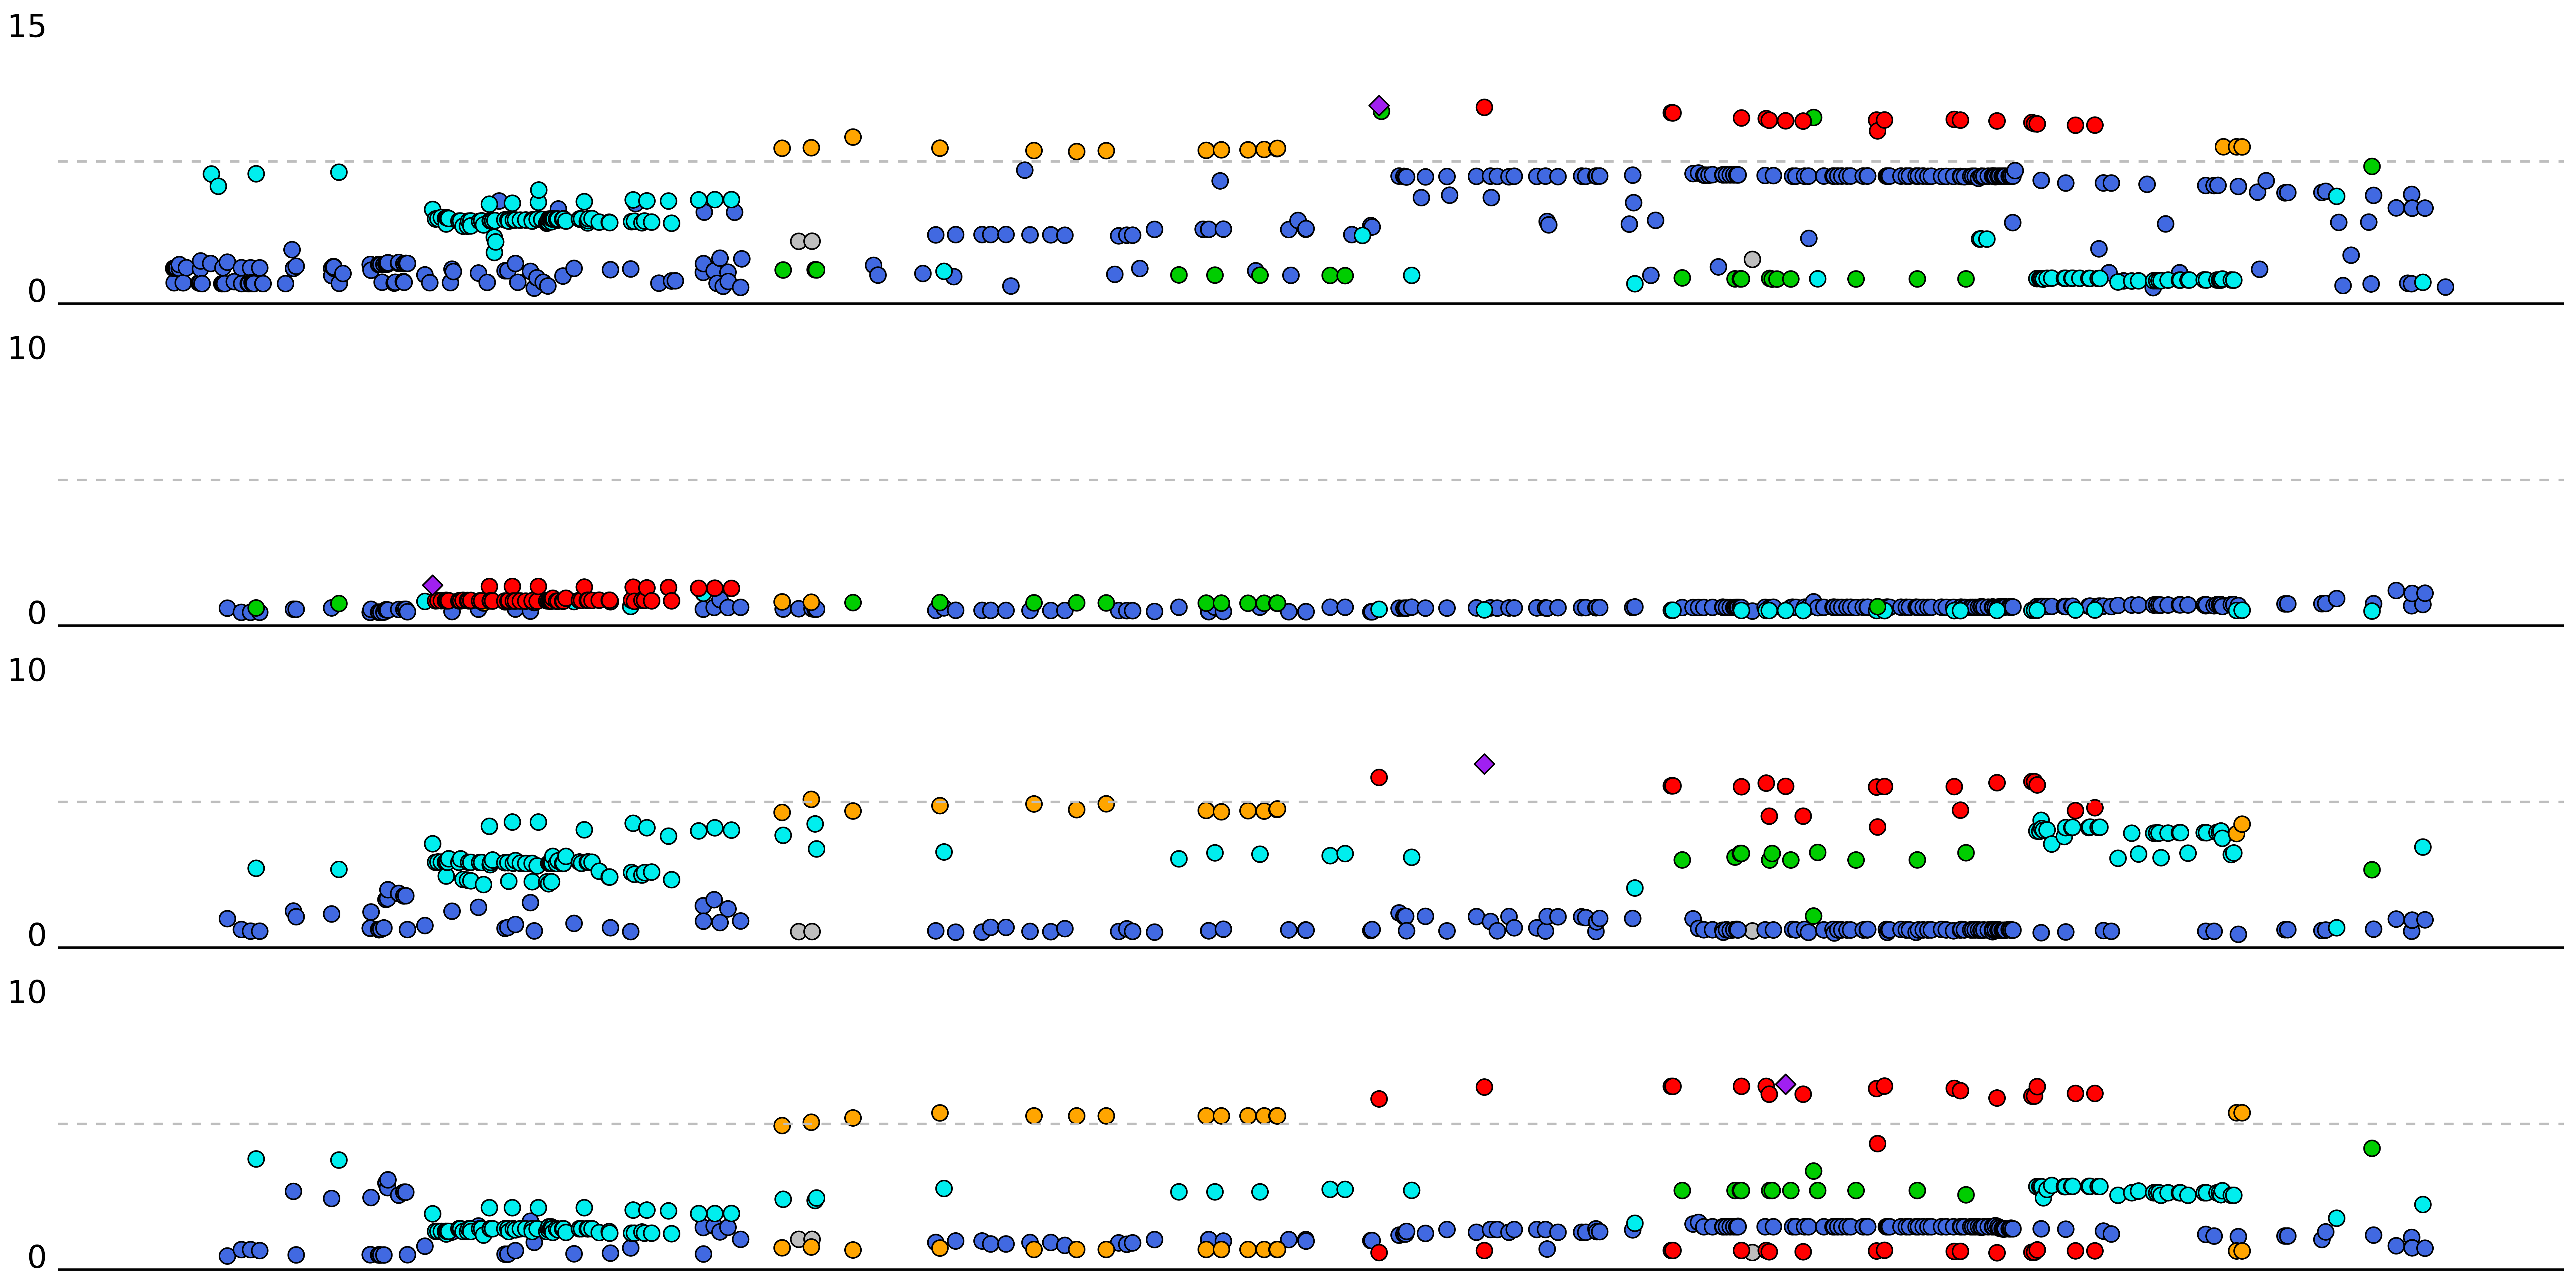

In [33]:
options(repr.plot.width=16, repr.plot.height=8, repr.plot.res=500)
ymax = 15
ymax2 = 10
ymax3 = 10
ycut = 5
s = 3
p0 <- gg_scatter(loc_gwas, labels=NULL, xticks = FALSE, legend_pos=NULL, size=s, pcutoff=5e-8) + 
    scale_y_continuous(breaks = c(0, ymax), limits=c(0,ymax)) +
    theme(axis.text=element_text(size=14), axis.title=element_blank(), plot.title = element_text(color="black", size=16, hjust=0.5),
          axis.line.y=element_blank(), axis.ticks = element_blank(),
          legend.text=element_text(size=10), legend.title=element_text(size=14), legend.background=element_rect(fill = alpha("white", 0.0)))
p1 <- gg_scatter(loc_eqtl, labels=NULL, xticks = FALSE, legend_pos=NULL, size=s, pcutoff=1e-5) +
    scale_y_continuous(breaks = c(0, ymax2), limits=c(0,ymax2)) + geom_hline(yintercept = 5, colour = "grey", linetype = "dashed") +
    theme(axis.text=element_text(size=14), axis.title=element_blank(), plot.title = element_text(color="black", size=16, hjust=0.5),
          axis.line.y=element_blank(), axis.ticks = element_blank(),
          legend.text=element_text(size=10), legend.title=element_text(size=14), legend.background=element_rect(fill = alpha("white", 0.0)))
p2 <- gg_scatter(loc_ibsep, labels=NULL, xticks = FALSE, legend_pos=NULL, size=s, pcutoff=1e-5) + 
    scale_y_continuous(breaks = c(0, ymax2), limits=c(0,ymax2)) + geom_hline(yintercept = 5, colour = "grey", linetype = "dashed") +
    theme(axis.text=element_text(size=14), axis.title=element_blank(), axis.line.y=element_blank(), axis.ticks = element_blank(),
         legend.text=element_text(size=10), legend.title=element_text(size=14), legend.background=element_rect(fill = alpha("white", 0.0)))
p3 <- gg_scatter(loc_onek1k, labels=NULL, xticks = FALSE, legend_pos=NULL, size=s, pcutoff=1e-5) + 
    scale_y_continuous(breaks = c(0, ymax3), limits=c(0,ymax3)) + geom_hline(yintercept = 5, colour = "grey", linetype = "dashed") +
    theme(axis.text=element_text(size=14), axis.title=element_blank(), axis.line.y=element_blank(), axis.ticks = element_blank(),
         legend.text=element_text(size=10), legend.title=element_text(size=14), legend.background=element_rect(fill = alpha("white", 0.0)))
g <- gg_genetracks(loc_ibsep, maxrows=3, filter_gene_biotype='protein_coding') + 
    theme(axis.text.x=element_text(size=10), axis.title.x=element_text(size=14))

plot_grid(p0, p1, p2, p3, ncol = 1, rel_heights = c(2., 2., 2., 2.), align = "v")

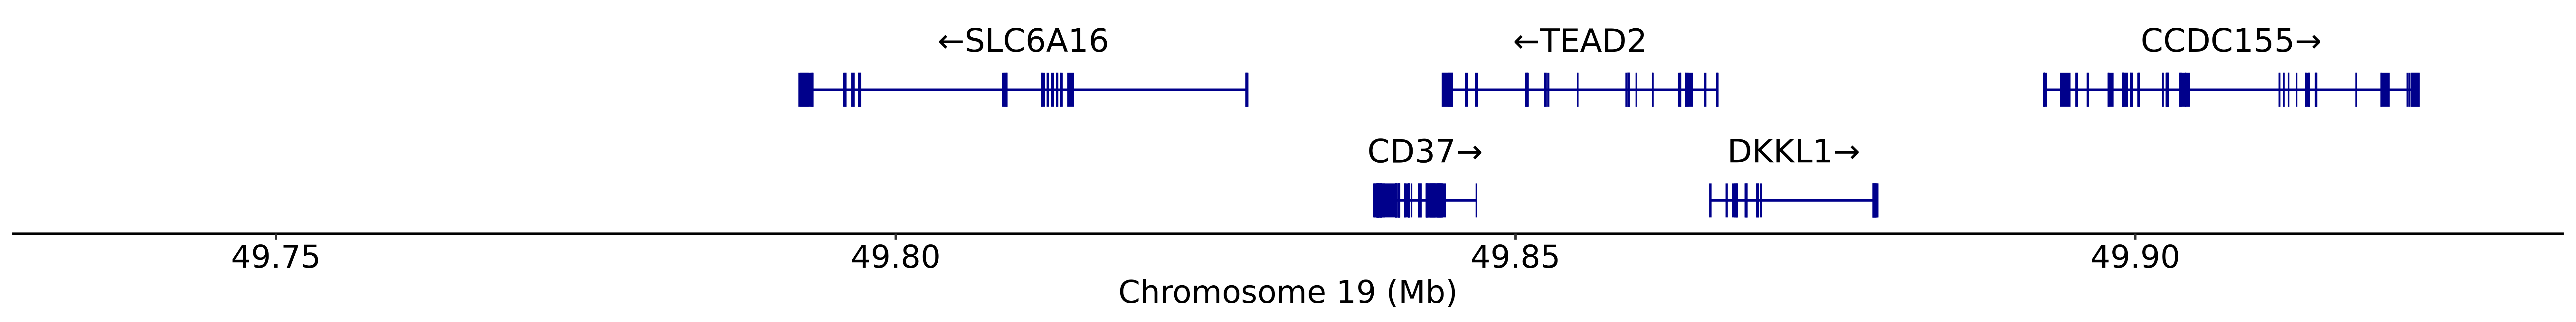

In [88]:
options(repr.plot.width=16, repr.plot.height=2, repr.plot.res=500)
gg_genetracks(loc_ibsep, maxrows=3, filter_gene_biotype='protein_coding', cex.text=1.2) + 
    theme(axis.text.x=element_text(size=14), axis.title.x=element_text(size=14))